In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
sns.set(style = "whitegrid")
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from sklearn import preprocessing



# Data Info

In [4]:
UPS= pd.read_csv('Twitter_volume_UPS.csv')

In [5]:
UPS.head()

,timestamp,value
0,2015-02-26 21:42:53,2
1,2015-02-26 21:47:53,2
2,2015-02-26 21:52:53,4
3,2015-02-26 21:57:53,3
4,2015-02-26 22:02:53,5


In [6]:
UPS.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15866 entries, 0 to 15865
Data columns (total 2 columns):
timestamp    15866 non-null object
value        15866 non-null int64
dtypes: int64(1), object(1)
memory usage: 248.0+ KB


# Part 1: Data Exploration

In [44]:
UPS['value'].value_counts()

0      4400
1      3282
2      2486
3      1691
4      1167
5       738
6       556
7       309
8       221
9       151
10      119
11       70
12       62
13       45
15       32
14       27
17       19
16       19
18       15
20       13
23        9
22        9
19        9
186       8
21        7
27        6
179       6
190       6
29        6
176       6
       ... 
182       1
131       1
155       1
33        1
138       1
122       1
165       1
157       1
58        1
50        1
108       1
133       1
26        1
117       1
93        1
62        1
225       1
217       1
201       1
77        1
177       1
91        1
145       1
137       1
121       1
123       1
126       1
81        1
49        1
231       1
Name: value, Length: 188, dtype: int64

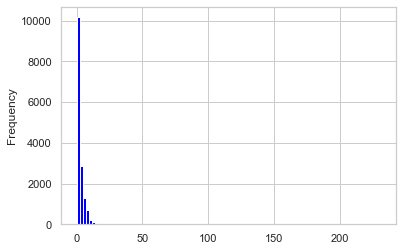

In [45]:
UPS.value.plot.hist(bins=100, density=False,color='blue')

It is shown from the histogram that  0 to 6 have the highest frequency.

In [21]:
UPS['timestamp'] = pd.to_datetime(UPS['timestamp'])

In [22]:
UPS.head()

,timestamp,value
0,2015-02-26 21:42:53,2
1,2015-02-26 21:47:53,2
2,2015-02-26 21:52:53,4
3,2015-02-26 21:57:53,3
4,2015-02-26 22:02:53,5


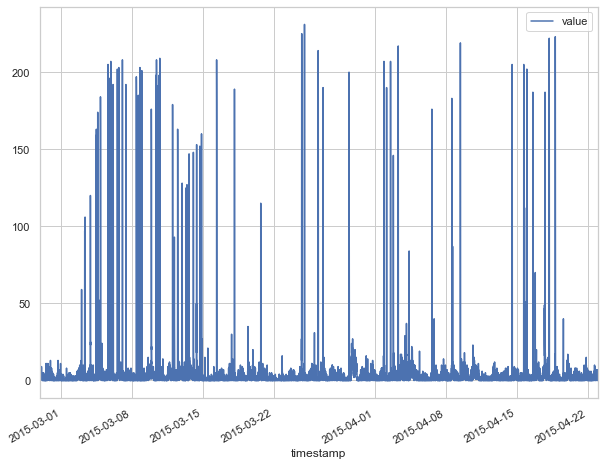

In [23]:
UPS.plot(x='timestamp',y='value',figsize=(10,8))

The data is very dense in a low value range, while quite sparse in a high value range.

In [24]:
UPS['Hours'] = UPS['timestamp'].dt.hour
UPS['Year'] = UPS['timestamp'].dt.year
UPS['Month'] = UPS['timestamp'].dt.month
UPS['Day'] = UPS['timestamp'].dt.day
UPS['Day_Of_Week'] = UPS['timestamp'].dt.dayofweek

In [25]:
UPS.head()

,timestamp,value,Hours,Year,Month,Day,Day_Of_Week
0,2015-02-26 21:42:53,2,21,2015,2,26,3
1,2015-02-26 21:47:53,2,21,2015,2,26,3
2,2015-02-26 21:52:53,4,21,2015,2,26,3
3,2015-02-26 21:57:53,3,21,2015,2,26,3
4,2015-02-26 22:02:53,5,22,2015,2,26,3


In [26]:
UPS['Month'].value_counts()

3    8928
4    6334
2     604
Name: Month, dtype: int64

In [27]:
UPS['Day_Of_Week'].value_counts()

6    2304
5    2304
4    2304
1    2304
0    2304
2    2302
3    2044
Name: Day_Of_Week, dtype: int64

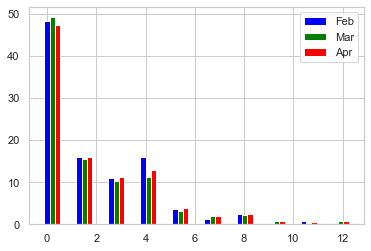

In [46]:
a = UPS.loc[UPS['Month'] == 2, 'value'] 
b = UPS.loc[UPS['Month'] == 3, 'value']
c= UPS.loc[UPS['Month'] ==4, 'value']
 

fig, ax = plt.subplots()
a_heights, a_bins = np.histogram(a)
b_heights, b_bins = np.histogram(b, bins=a_bins)
c_heights, c_bins = np.histogram(c, bins=a_bins)
 

width = (a_bins[1] - a_bins[0])/6

ax.bar(a_bins[:-1], a_heights*100/a.count(), width=width, facecolor='blue', label='Feb')
ax.bar(b_bins[:-1]+width, (b_heights*100/b.count()), width=width, facecolor='green', label ='Mar')
ax.bar(c_bins[:-1]+width*2, (c_heights*100/c.count()), width=width, facecolor='red', label ='Apr')
 
plt.legend()
plt.show()

Visulization for data amount for three different monthes.

# Part 2:  Anomaly Detection

# Model 1:  Isolation Forest 

In [47]:

from sklearn.ensemble import IsolationForest

data =UPS[['value', 'Hours', 'Year', 'Month', 'Day_Of_Week']]
min_max_scaler = preprocessing.StandardScaler()
np_scaled = min_max_scaler.fit_transform(data)
data = pd.DataFrame(np_scaled)
# train isolation forest 
model =  IsolationForest(contamination = 0.01)
model.fit(data)
# add the data to the main  
UPS['anomaly'] = pd.Series(model.predict(data))
UPS['anomaly'] = UPS['anomaly'].map( {1: 0, -1: 1} )
print(UPS['anomaly'].value_counts())

/Users/xurui1993/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:247: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/xurui1993/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:415: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)


0    15707
1      159
Name: anomaly, dtype: int64


In [48]:
UPS['time_epoch'] = (UPS['timestamp'].astype(np.int64)/100000000000).astype(np.int64)

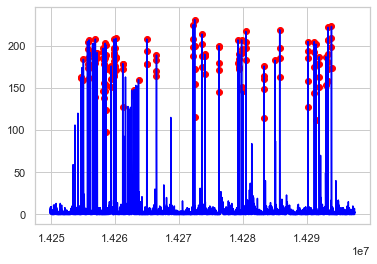

In [49]:
fig, ax = plt.subplots()

a = UPS.loc[UPS['anomaly'] == 1, ['time_epoch', 'value']] #anomaly

ax.plot(UPS['time_epoch'], UPS['value'], color='blue')
ax.scatter(a['time_epoch'],a['value'], color='red')
plt.show()

# Model 2: One-Class SVM

In [50]:
from sklearn.svm import OneClassSVM

In [53]:
data = UPS[['value', 'Hours', 'Year', 'Month', 'Day_Of_Week']]
min_max_scaler = preprocessing.StandardScaler()
np_scaled = min_max_scaler.fit_transform(data)
# train one class SVM 
model =  OneClassSVM(nu=0.95 * 0.01) 
data = pd.DataFrame(np_scaled)
model.fit(data)

UPS['anomaly2'] = pd.Series(model.predict(data))
UPS['anomaly2'] = UPS['anomaly2'].map( {1: 0, -1: 1} )
print(UPS['anomaly2'].value_counts())

0    15659
1      207
Name: anomaly2, dtype: int64


/Users/xurui1993/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


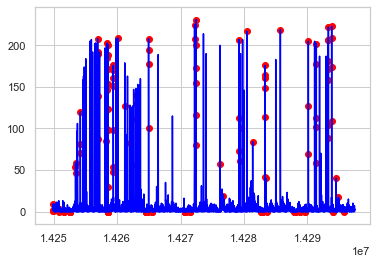

In [54]:
fig, ax = plt.subplots()

a = UPS.loc[UPS['anomaly2'] == 1, ['time_epoch', 'value']] #anomaly

ax.plot(UPS['time_epoch'], UPS['value'], color='blue')
ax.scatter(a['time_epoch'], a['value'], color='red')
plt.show()

Comparing the above two models,  one-class SVM detect more outliers than Isolation Forest.